In [1]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pylab import *
from keras.callbacks import LearningRateScheduler
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
# from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
import itertools
from sklearn.metrics import confusion_matrix
from keras import optimizers
from PIL import Image
import pandas as pd
import os

In [2]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch / step_size))
        return LearningRateScheduler(schedule)

In [3]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
model = models.Sequential()
    
for layer in vgg_conv.layers:
    layer.trainable = False

# Check the trainabl status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


model.add(vgg_conv)
model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.25))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
# model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

# optimizer = optimizers.Adagrad(lr=0.0001, epsilon=None, decay=0.0)
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              # loss="mean_squared_error",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


<keras.engine.input_layer.InputLayer object at 0x7f0217400f10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f02173b9a10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f021735c0d0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f021735cbd0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f02142eee90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f02142f5210> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f02142fb990> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f02143015d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0214301d90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0214312910> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0214312e50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f02142ee9d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0214304ed0> False
<keras.layers.convolut

In [5]:
lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TRAINING_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
train_datagen = ImageDataGenerator(
#       rescale=1./255
      # ,rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
)
# test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary')
VALIDATION_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [7]:
history = model.fit(
      train_generator,
      steps_per_epoch=500,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks=[lr_sched]
)

Epoch 1/10
500/500 [==============================] - 135s 251ms/step - loss: 5.1698 - accuracy: 0.7822 - val_loss: 0.3808 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 2/10
500/500 [==============================] - 117s 234ms/step - loss: 0.3413 - accuracy: 0.8566 - val_loss: 0.3124 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 3/10
500/500 [==============================] - 109s 218ms/step - loss: 0.2698 - accuracy: 0.8932 - val_loss: 0.3199 - val_accuracy: 0.8625 - lr: 7.5000e-04
Epoch 4/10
500/500 [==============================] - 102s 203ms/step - loss: 0.2316 - accuracy: 0.9098 - val_loss: 0.2561 - val_accuracy: 0.8906 - lr: 7.5000e-04
Epoch 5/10
500/500 [==============================] - 98s 196ms/step - loss: 0.1878 - accuracy: 0.9256 - val_loss: 0.2300 - val_accuracy: 0.9000 - lr: 5.6250e-04
Epoch 6/10
500/500 [==============================] - 98s 195ms/step - loss: 0.1747 - accuracy: 0.9325 - val_loss: 0.2174 - val_accuracy: 0.9125 - lr: 5.6250e-04
Epoch 7/10
500/500 [============

In [22]:
model.save('model_vgg16.h5')

In [9]:
TEST_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [10]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle = False)

Found 20000 images belonging to 2 classes.


In [11]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

625/625 [==============================] - 110s 173ms/step - loss: 0.2123 - accuracy: 0.9232


[0.2123321294784546, 0.9231500029563904]

In [12]:
print(model.metrics_names)

['loss', 'accuracy']


In [13]:
THRESH=0.5
test_predict_proba = model.predict(test_generator)
test_predict = np.where(test_predict_proba > THRESH,1,0)

test_predict

625/625 [==============================] - 101s 162ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [14]:
test_predict_proba

array([[0.00432426],
       [0.00397263],
       [0.07223966],
       ...,
       [0.01307952],
       [0.72385025],
       [0.999668  ]], dtype=float32)

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

In [45]:
test_predict

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

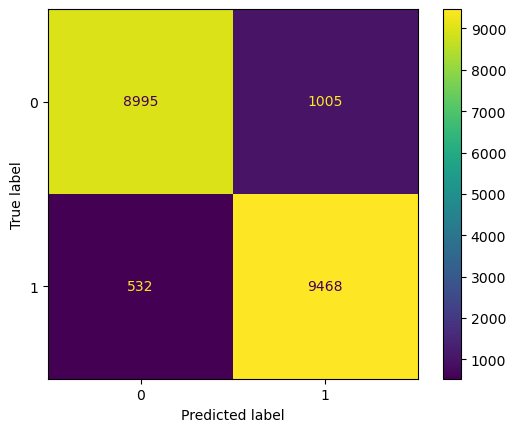

In [46]:
cm = confusion_matrix(test_generator.classes, test_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [32]:
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle = False)

Found 100000 images belonging to 2 classes.


In [34]:
THRESH=0.5
train_predict_proba = model.predict(train_generator)
train_predict = np.where(train_predict_proba > THRESH,1,0)

train_predict

3125/3125 [==============================] - 510s 163ms/step


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [38]:
train_predict_proba

array([[1.8842639e-02],
       [4.0794045e-04],
       [3.9133755e-03],
       ...,
       [9.9944621e-01],
       [9.9994135e-01],
       [6.4308333e-01]], dtype=float32)

In [47]:
train_predict

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

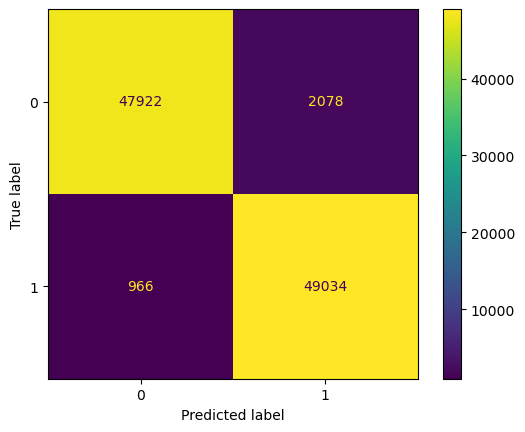

In [39]:
cm = confusion_matrix(train_generator.classes, train_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [40]:
f1_score(train_generator.classes, train_predict)

0.9698947701558667

In [48]:
VALIDATION_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'

In [50]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle = False)

Found 20000 images belonging to 2 classes.


In [51]:
THRESH=0.5
valid_predict_proba = model.predict(valid_generator)
valid_predict = np.where(valid_predict_proba > THRESH,1,0)

valid_predict

625/625 [==============================] - 162s 260ms/step


array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [52]:
valid_predict_proba

array([[0.17455244],
       [0.00696111],
       [0.51345885],
       ...,
       [0.9999832 ],
       [0.96290416],
       [0.98715657]], dtype=float32)

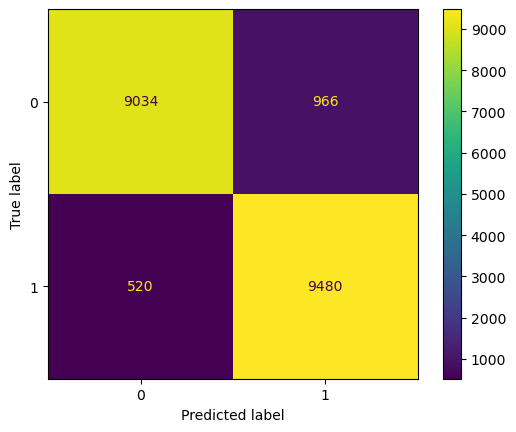

In [53]:
cm = confusion_matrix(valid_generator.classes, valid_predict, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot()
plt.show()

In [56]:
import sklearn.metrics as metrics
from sklearn.metrics import f1_score

In [57]:
f1_score(valid_generator.classes, valid_predict)

0.9273207473344419

In [ ]:
f1_score(train_generator.classes, train_predict)

In [20]:
TEST_DIR = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(224,224),batch_size=32,class_mode='binary', shuffle = False)

In [ ]:
model.load_weights('model_vgg16') # initialize the best trained weights

true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

In [ ]:
test_img = image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test', target_size=(224,224),batch_size=32,class_mode='binary')
test_img

In [ ]:
# Converting image to array
test_img = np.asarray(test_img)

# Expanding the dimensions
test_img = np.expand_dims(test_img, axis=0)

In [ ]:

# Predicting the loaded image
output = model.predict(test_img)

# Condition of checking the label of the loaded or tested image
if output[0][0] > output[0][1]:
    print("Cat")
else:
    print("Dog")